<a href="https://colab.research.google.com/github/hamydang16/EY_Data-Challenge-2025/blob/main/UHI_Experiment_Sample_Benchmark_Notebook_V7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Urban Heat Island (UHI) Benchmark Notebook

## Challenge Overview

<p align="justify">Welcome to the EY Open Science AI & Data Challenge 2025! The objective of this challenge is to build a machine learning model to predict urban heat island (UHI) hotspots in a city. By the end of the challenge, you will have developed a regression model capable of predicting the intensity of the UHI effect.

Participants will be given ground-level air temperature data in an index format, which was collected on 24th July 2021 on traverse points in the Bronx and Manhattan regions of New York city. This dataset constitutes traverse points (latitude and longitude) and their corresponding UHI (Urban Heat Island) index values. Participants will use this dataset to build a regression model to predict UHI index values for a given set of locations. It is important to understand that the UHI Index at any given location is indicative of the relative temperature elevation at that specific point compared to the city's average temperature.

This challenge is designed for participants with varying skill levels in data science and programming, offering a great opportunity to apply your knowledge and enhance your capabilities in the field.</p>

<b>Challenge Aim: </b><p align="justify"> <p>

<p align="justify">In this notebook, we will demonstrate a basic model workflow that can serve as a starting point for the challenge. The basic model has been constructed to predict the Urban Heat Island (UHI) index using features from the Sentinel-2 satellite dataset as predictor variables. In this demonstration, we utilized three features from the Sentinel-2 dataset: band B01 (Coastal Aerosol), band B06 (Red Edge), and NDVI (Normalized Difference Vegetation Index) derived from bands B04 (Red) and B08 (Near Infrared). A random forest regression model was then trained using these features.
    
These features were extracted from a GeoTIFF image created by the Sentinel-2 sample notebook. For the sample model shown in this notebook, data from a single day (24th July 2021) was considered, assuming that the values of bands B01, B04, B06, and B08 for this specific date are representative of the UHI index behavior at any location. Participants should review the details of the Sentinel-2 sample notebook to gain an understanding of the data and options for modifying the output product.
    
</p>

<p align="justify">Most of the functions presented in this notebook were adapted from the <a href="https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook">Sentinel-2-Level-2A notebook</a> found in the Planetary Computer portal.</p>

<p align="justify">Please note that this notebook is just a starting point. We have made many assumptions in this notebook that you may think are not best for solving the challenge effectively. You are encouraged to modify these functions, rewrite them, or try an entirely new approach.</p>


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install rioxarray
!pip install stackstac
!pip install pystac_client
!pip install planetary_computer
!pip install odc-stac
!pip install rasterstats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 947.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.8/153.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 12.0 MB/s eta 0:00:00


## Load In Dependencies

To run this demonstration notebook, you will need to have the following packages imported below installed. This may take some time.  

In [3]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Multi-dimensional arrays and datasets
import xarray as xr

# Geospatial raster data handling
import rioxarray as rxr

# Geospatial data analysis
import geopandas as gpd

# Geospatial operations
import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp
from rasterio.warp import transform_bounds
from rasterio.windows import from_bounds

# Image Processing
from PIL import Image

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Feature Engineering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
import xgboost as xgb
from sklearn.metrics import r2_score

# Planetary Computer Tools
import pystac_client
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo

# Others
import os
from tqdm import tqdm
from shapely.geometry import Point
from geopy.distance import geodesic
from rasterstats import zonal_stats

## Response Variable

Before building the model, we need to load in the Urban Heat Island (UHI) index training dataset. We have curated data for the New York region. The dataset consists of geo-locations (Longitude and Latitude), with additional fields including date & time of data collection and the UHI index for each location.

<h10 style="color:rgb(255, 255, 0)"><strong>Note: Participants are strictly prohibited from using Longitude and Latitude values as features in building their machine learning models. These values should only be utilized for understanding the attributes and characteristics of the locations. Submissions that employ longitude and latitude values as model features will be disqualified.</strong></h10>

<h10 style="color:rgb(255, 255, 0)"><strong>Incorporating latitude and longitude data in their raw forms or through any form of manipulation—including multiplication, embedding, or conversion to polar coordinates—as predictive features in your model is strictly prohibited, as it can compromise the adaptability of your model across diverse scenarios. This prohibition extends to calculating the distance from a reference point and using it as a feature, which is essentially a transformation of the original geographical coordinates into a new feature form. Submissions that include these types of features will be considered non-compliant and will be disqualified.</strong></h10>

In [4]:
csv_path = '/content/drive/MyDrive/Colab Notebooks/EY Data Challenge/Training_data_uhi_index_2025-02-18.csv'

In [5]:
# Load the training data from csv file and display the first few rows to inspect the data
ground_df = pd.read_csv(csv_path)
ground_df.head()

,Longitude,Latitude,datetime,UHI Index
0,-73.909167,40.813107,24-07-2021 15:53,1.030289
1,-73.909187,40.813045,24-07-2021 15:53,1.030289
2,-73.909215,40.812978,24-07-2021 15:53,1.023798
3,-73.909242,40.812908,24-07-2021 15:53,1.023798
4,-73.909257,40.812845,24-07-2021 15:53,1.021634


## Weather data

In [6]:
#Change datetime object
ground_df['datetime'] = pd.to_datetime(ground_df['datetime'])

In [7]:
# prompt: check to see if the point defined by latitude and longitude in ground_df is within 5km radius of bronx ((40.8501, -73.8662). create a new column in ground_df


# Define the Bronx coordinates
bronx_coords = (40.8501, -73.8662)

# Function to check if a point is within a radius
def is_within_radius(row, radius_km=10):
    point_coords = (row['Latitude'], row['Longitude'])
    distance = geodesic(bronx_coords, point_coords).km
    return distance <= radius_km

# Apply the function and create the new column
ground_df['within_5km_of_bronx'] = ground_df.apply(is_within_radius, axis=1)
#replace False in within 5km of bronx with 'Manhattan' and True with 'Bronx'
ground_df['within_5km_of_bronx'] = ground_df['within_5km_of_bronx'].replace({False: 'Manhattan', True: 'Bronx'})

In [8]:
#rename column 'within_10km'
ground_df = ground_df.rename(columns={'within_5km_of_bronx': 'Region'})
ground_df.head()

,Longitude,Latitude,datetime,UHI Index,Region
0,-73.909167,40.813107,2021-07-24 15:53:00,1.030289,Bronx
1,-73.909187,40.813045,2021-07-24 15:53:00,1.030289,Bronx
2,-73.909215,40.812978,2021-07-24 15:53:00,1.023798,Bronx
3,-73.909242,40.812908,2021-07-24 15:53:00,1.023798,Bronx
4,-73.909257,40.812845,2021-07-24 15:53:00,1.021634,Bronx


In [9]:
ground_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11229 entries, 0 to 11228
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Longitude  11229 non-null  float64       
 1   Latitude   11229 non-null  float64       
 2   datetime   11229 non-null  datetime64[ns]
 3   UHI Index  11229 non-null  float64       
 4   Region     11229 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 438.8+ KB


In [10]:
## TEST
#Load the weather dataset, read only the bronx sheet
weather_bronx = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/EY Data Challenge/NY_Mesonet_Weather.xlsx', sheet_name='Bronx')
weather_manhattan = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/EY Data Challenge/NY_Mesonet_Weather.xlsx', sheet_name='Manhattan')

In [11]:
#/change datetime of weather bronx and weather manhattan
weather_bronx['Date / Time'] = pd.to_datetime(weather_bronx['Date / Time'])
weather_manhattan['Date / Time'] = pd.to_datetime(weather_manhattan['Date / Time'])

In [ ]:
weather_manhattan.head()

,Date / Time,Air Temp at Surface [degC],Relative Humidity [percent],Avg Wind Speed [m/s],Wind Direction [degrees],Solar Flux [W/m^2]
0,2021-07-24 06:00:00,21.3,66.5,0.9,348,10
1,2021-07-24 06:05:00,21.4,66.1,1.1,345,12
2,2021-07-24 06:10:00,21.4,66.5,1.3,4,14
3,2021-07-24 06:15:00,21.5,65.4,1.3,5,17
4,2021-07-24 06:20:00,21.5,65.0,1.5,346,19


In [12]:
# prompt: merge ground_df and weather_bronx where region is bronx and date/time matches by the near hour and minutes

# Assuming ground_df and weather_bronx are already loaded as in your provided code

# Function to find the nearest hour and minute match in weather data
def nearest_time_match(ground_time, weather_df):
    # Calculate time differences in minutes
    time_diffs = abs((weather_df['Date / Time'] - ground_time).dt.total_seconds() / 60)

    # Find the index of the minimum time difference
    nearest_index = time_diffs.idxmin()

    return weather_df.loc[nearest_index]

# Apply the nearest_time_match function to each row in ground_df for Bronx region
ground_df_bronx = ground_df[ground_df['Region'] == 'Bronx'].copy()
merged_data = []
for index, row in ground_df_bronx.iterrows():
    try:
      nearest_weather = nearest_time_match(row['datetime'], weather_bronx)
      merged_row = pd.concat([row, nearest_weather])
      merged_data.append(merged_row)
    except:
      pass

# Create the merged DataFrame
merged_bronx = pd.DataFrame(merged_data)

merged_bronx.head()

,Longitude,Latitude,datetime,UHI Index,Region,Date / Time,Air Temp at Surface [degC],Relative Humidity [percent],Avg Wind Speed [m/s],Wind Direction [degrees],Solar Flux [W/m^2]
Unnamed 0,-73.909167,40.813107,2021-07-24 15:53:00,1.030289,Bronx,2021-07-24 15:55:00,27.2,47.3,2.6,165,621
Unnamed 1,-73.909187,40.813045,2021-07-24 15:53:00,1.030289,Bronx,2021-07-24 15:55:00,27.2,47.3,2.6,165,621
Unnamed 2,-73.909215,40.812978,2021-07-24 15:53:00,1.023798,Bronx,2021-07-24 15:55:00,27.2,47.3,2.6,165,621
Unnamed 3,-73.909242,40.812908,2021-07-24 15:53:00,1.023798,Bronx,2021-07-24 15:55:00,27.2,47.3,2.6,165,621
Unnamed 4,-73.909257,40.812845,2021-07-24 15:53:00,1.021634,Bronx,2021-07-24 15:55:00,27.2,47.3,2.6,165,621


In [13]:
# Apply the nearest_time_match function to each row in ground_df for Manhattan region
ground_df_manhattan = ground_df[ground_df['Region'] == 'Manhattan'].copy()
merged_data = []
for index, row in ground_df_manhattan.iterrows():
    try:
      nearest_weather = nearest_time_match(row['datetime'], weather_manhattan)
      merged_row = pd.concat([row, nearest_weather])
      merged_data.append(merged_row)
    except:
      pass

# Create the merged DataFrame
merged_manhattan = pd.DataFrame(merged_data)

merged_manhattan.head()

,Longitude,Latitude,datetime,UHI Index,Region,Date / Time,Air Temp at Surface [degC],Relative Humidity [percent],Avg Wind Speed [m/s],Wind Direction [degrees],Solar Flux [W/m^2]
0,-73.981233,40.784337,2021-07-24 15:36:00,1.009974,Manhattan,2021-07-24 15:35:00,26.8,47.6,2.4,209,511
1,-73.981257,40.784328,2021-07-24 15:36:00,1.007810,Manhattan,2021-07-24 15:35:00,26.8,47.6,2.4,209,511
2,-73.981285,40.784322,2021-07-24 15:36:00,1.007810,Manhattan,2021-07-24 15:35:00,26.8,47.6,2.4,209,511
3,-73.981318,40.784297,2021-07-24 15:36:00,1.007810,Manhattan,2021-07-24 15:35:00,26.8,47.6,2.4,209,511
4,-73.981338,40.784268,2021-07-24 15:36:00,1.007810,Manhattan,2021-07-24 15:35:00,26.8,47.6,2.4,209,511


In [14]:
#combine merge_bronx and merge_manhattan
ground_df = pd.concat([merged_bronx, merged_manhattan])
ground_df.head()

,Longitude,Latitude,datetime,UHI Index,Region,Date / Time,Air Temp at Surface [degC],Relative Humidity [percent],Avg Wind Speed [m/s],Wind Direction [degrees],Solar Flux [W/m^2]
Unnamed 0,-73.909167,40.813107,2021-07-24 15:53:00,1.030289,Bronx,2021-07-24 15:55:00,27.2,47.3,2.6,165,621
Unnamed 1,-73.909187,40.813045,2021-07-24 15:53:00,1.030289,Bronx,2021-07-24 15:55:00,27.2,47.3,2.6,165,621
Unnamed 2,-73.909215,40.812978,2021-07-24 15:53:00,1.023798,Bronx,2021-07-24 15:55:00,27.2,47.3,2.6,165,621
Unnamed 3,-73.909242,40.812908,2021-07-24 15:53:00,1.023798,Bronx,2021-07-24 15:55:00,27.2,47.3,2.6,165,621
Unnamed 4,-73.909257,40.812845,2021-07-24 15:53:00,1.021634,Bronx,2021-07-24 15:55:00,27.2,47.3,2.6,165,621


In [15]:
ground_df = ground_df.reset_index()

In [16]:
#drop column
ground_df = ground_df.drop(columns=['Date / Time', 'Region', 'Air Temp at Surface [degC]', 'index'])

## Predictor Variables

<p align="justify">Now that we have our UHI data, it is time to gather the predictor variables from the Sentinel-2 dataset. Participants should review the provided Sentinel-2 sample notebook as it was used to create a sample GeoTIFF for this models. For a more in-depth look regarding the Sentinel-2 dataset and how to query it, see the Microsoft Planetary Computer example <a href="https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook">Sentinel-2 supplementary notebook</a>. </p>

<p align="justify">Sentinel-2 optical data provides high-resolution imagery that is sensitive to land surface characteristics, which are crucial for understanding urban heat dynamics. Band values such as B01 (Coastal aerosol), B06 (Red Edge), and NDVI (Normalized Difference Vegetation Index) derived from B04 (Red) and B08 (Near Infrared) help us in estimating the UHI index. Hence, we are choosing B01, B06, and NDVI as predictor variables for this experiment.</p>

<ul>
<li>B01 - Reflectance values from the Coastal aerosol band, which help in assessing aerosol presence and improving atmospheric correction.</li>

<li>B06 - Reflectance values from the Red Edge band, which provide useful information for detecting vegetation, water bodies, and urban surfaces.</li>

<li>NDVI - Derived from B04 (Red) and B08 (Near Infrared), NDVI is an important indicator for vegetation health and land cover.</li>
</ul>


<h4 style="color:rgb(255, 255, 0)"><strong>Tip 1</strong></h4>
<p align="justify">Participants might explore other combinations of bands from the Sentinel-2 and from other satellite datasets as well. For example, you can use mathematical combinations of bands to generate various indices </a> which can then be used as features in your model. These bands or indices may provide insights into surface characteristics, vegetation, or built-up areas that could influence UHI patterns.

### Analyze the Sentinel-2 Data

<p align="justify">To obtain the Sentinel-2 data, we created a GeoTIFF image for a specific date and area of interest, which in this case is the Bronx and Manhattan regions of New York. The GeoTIFF product allows us to extract the relevant band values. In this example, we extracted B01 (Coastal Aerosol), B04 (Red), B06 (Red Edge), and B08 (Near Infrared) values for a single day (24th July, 2021). Participants should review the provided Sentinel-2 sample notebook for common output images (RGB, NDVI) and methods to alter the output.</p>

### Methods of Extracting Band Values from Sentinel-2 Data

There are two common methods to extract band values from Sentinel-2 data:

<ul>
    <li><strong>Using API Calls:</strong> Retrieve band values directly from Sentinel-2 datasets via APIs, such as the <code>planetary_computer</code>.</li>
</ul>
<ul>
    <li><strong>Using GeoTIFF Images:</strong> Create and download a GeoTIFF image containing the desired bands and extract the band values locally. The GeoTIFF image can represent any desired time period (single date or time series mosaic) and include any number of spectral bands.</li>
</ul>

Participants can select any of these approaches as per their convenience. Since our dataset is large, the API method can be time-consuming and resource-intensive. Therefore, in this sample notebook, we have opted for the second method and extracted the values for bands B01, B04, B08, and B06. Please refer to the Sentinel-2 sample notebook for details about the creation of the GeoTIFF image.

<h4 style="color:rgb(255, 255, 0)"><strong>Tip 2</strong></h4>
<p align="justify"> Rather than extracting the bands for a single day coincident with the ground-based data collection, participants might explore other options to improve data quality. For example, one could select a different single date with minimal or no cloud cover or generate a median mosaic using several scenes within a time series. See the Sentinel-2 sample notebook for examples.</p>

### Downloading GeoTIFF Image

For building a sample model in this demonstration notebook, we have downloaded a GeoTIFF file locally for a single day (24th July 2021). The file is named <b>S2_sample.tiff</b>. This GeoTIFF file contains values of four bands: Band B01, Band B04, Band B06 and Band B08. In the subsequent section, we will use this GeoTIFF file to extract the band values for the geo-locations given in the training dataset to create the features.

First, let’s visualize the bands of the downloaded GeoTIFF image.

In [17]:
# Open the GeoTIFF file
tiff_path = '/content/drive/MyDrive/Colab Notebooks/EY Data Challenge/S2_sample.tiff'

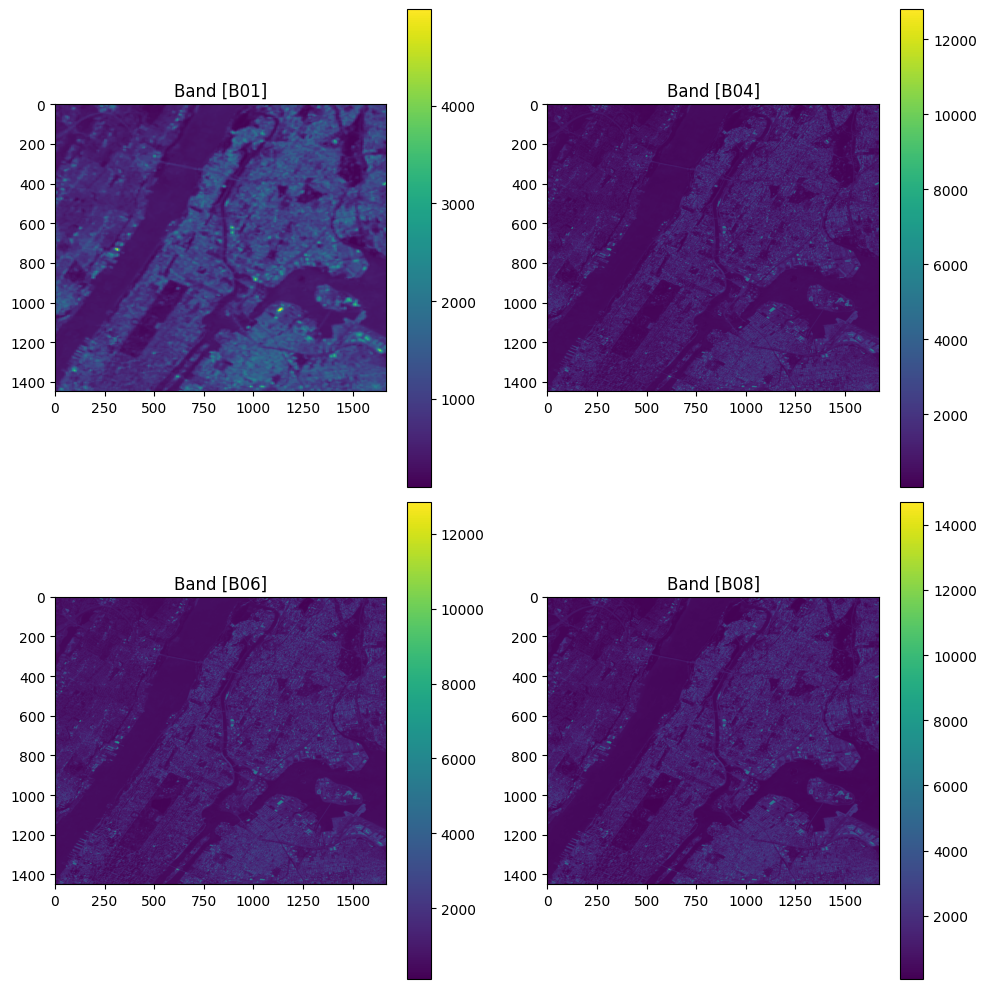

In [ ]:
# Reads and plots four bands (B04, B08, B06, B01) from the GeoTIFF file.

# Open the GeoTIFF file
tiff_path = '/content/drive/MyDrive/Colab Notebooks/EY Data Challenge/S2_sample.tiff'

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path) as src1:
    band1 = src1.read(1)  # Band [B01]
    band2 = src1.read(2)  # Band [B04]
    band3 = src1.read(3)  # Band [B06]
    band4 = src1.read(4)  # Band [B08]

# Plot the bands in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the axes for easier indexing
axes = axes.flatten()

# Plot the first band (B01)
im1 = axes[0].imshow(band1, cmap='viridis')
axes[0].set_title('Band [B01]')
fig.colorbar(im1, ax=axes[0])

# Plot the second band (B04)
im2 = axes[1].imshow(band2, cmap='viridis')
axes[1].set_title('Band [B04]')
fig.colorbar(im2, ax=axes[1])

# Plot the third band (B08)
im3 = axes[2].imshow(band3, cmap='viridis')
axes[2].set_title('Band [B06]')
fig.colorbar(im3, ax=axes[2])

# Plot the fourth band (B12)
im4 = axes[3].imshow(band4, cmap='viridis')
axes[3].set_title('Band [B08]')
fig.colorbar(im4, ax=axes[3])

plt.tight_layout()
plt.show()


<h4 style="color:rgb(255, 255, 0)"><strong>Tip 3</strong></h4>

Instead of a single point data extraction, participants might explore the approach of creating a focal buffer around the locations (e.g., 50 m, 100 m, 150 m etc). For example, if the specified distance was 50 m and the specified band was “Band 2”, then the value of the output pixels from this analysis would reflect the average values in band 2 within 50 meters of the specific location. This approach might help reduction in error associated with spatial autocorrelation. In this demonstration notebook, we are extracting the band data for each of the locations without creating a buffer zone.




### Extracting Band Values from the GeoTIFF Image


In [ ]:
# Extracts satellite band values from a GeoTIFF based on coordinates from a csv file and returns them in a DataFrame.

def map_satellite_data(tiff_path, csv_path):

    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path)
    tiff_crs = data.rio.crs

    # Read the Excel file using pandas
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # 3. Convert lat/long to the GeoTIFF's CRS
    # Create a Proj object for EPSG:4326 (WGS84 - lat/long) and the GeoTIFF's CRS
    proj_wgs84 = Proj(init='epsg:4326')  # EPSG:4326 is the common lat/long CRS
    proj_tiff = Proj(tiff_crs)

    # Create a transformer object
    transformer = Transformer.from_proj(proj_wgs84, proj_tiff)

    B01_values = []
    B02_values = []
    B03_values = []
    B04_values = []
    B08_values = []
    B12_values = []

# Iterate over the latitudes and longitudes, and extract the corresponding band values
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
    # Assuming the correct dimensions are 'y' and 'x' (replace these with actual names from data.coords)

        B01_value = data.sel(x=lon, y=lat,  band=1, method="nearest").values
        B01_values.append(B01_value)


        B02_value = data.sel(x=lon, y=lat,  band=2, method="nearest").values
        B02_values.append(B02_value)

        B03_value = data.sel(x=lon, y=lat,  band=3, method="nearest").values
        B03_values.append(B03_value)

        B04_value = data.sel(x=lon, y=lat, band=4, method="nearest").values
        B04_values.append(B04_value)

        B08_value = data.sel(x=lon, y=lat, band=5, method="nearest").values
        B08_values.append(B08_value)

        B12_value = data.sel(x=lon, y=lat, band=6, method="nearest").values
        B12_values.append(B12_value)

    # Create a DataFrame with the band values
    # Create a DataFrame to store the band values
    df = pd.DataFrame()
    df['B01'] = B01_values
    df['B02'] = B02_values
    df['B03'] = B03_values
    df['B04'] = B04_values
    df['B08'] = B08_values
    df['B12'] = B12_values

    return df


In [18]:
#Extracting lst data
from rasterio.windows import Window
import rasterio

def map_satellite_data2(tiff_path, csv_path):
    """
    Extract raster values at specified lat/lon coordinates from a GeoTIFF file.

    Parameters:
    -----------
    tiff_path : str
        Path to the GeoTIFF file
    csv_path : str
        Path to CSV file containing 'Latitude' and 'Longitude' columns

    Returns:
    --------
    pd.DataFrame
        DataFrame containing original coordinates and extracted values
    """
    # Read points from CSV
    df = pd.read_csv(csv_path)

    # Open the raster file and extract values
    with rasterio.open(tiff_path) as src:
        coords = list(zip(df['Longitude'], df['Latitude']))
        lst_values = []

        for lon, lat in coords:
            try:
                row, col = src.index(lon, lat)
                window = Window(col, row, 1, 1)
                value = src.read(1, window=window)
                lst_values.append(float(value[0][0]))
            except (IndexError, ValueError):
                lst_values.append(None)

    # Create and return output DataFrame
    return pd.DataFrame({
        'Latitude': df['Latitude'],
        'Longitude': df['Longitude'],
        'LST': lst_values
    })

In [19]:
#Extracting spectral data from geotiff image, allowing for buffer zone
import rasterio as rio
import rioxarray as rxr
from shapely.geometry import Point, mapping


def test(tiff_path, csv_path, buffer_distance):
    # Read the CSV file using pandas
    df = pd.read_csv(csv_path)

    # Create points from coordinates
    geometry = [Point(lon, lat) for lon, lat in zip(df['Longitude'], df['Latitude'])]
    gdf = gpd.GeoDataFrame(df, crs='epsg:4326', geometry=geometry)

    # Initialize results DataFrame with original data
    results_df = df.copy()

    with rio.open(tiff_path) as src:
        # Transform points to raster CRS
        gdf = gdf.to_crs(src.crs)

        band_name_mapping = {
            1: 'B01',
            2: 'B02',
            3: 'B03',
            4: 'B04',
            5: 'B08',
            6: 'B12'
        }

        # Process each point individually
        for idx, point in enumerate(tqdm(gdf.geometry, desc="Processing locations")):
            # Create buffer for this specific point
            buffered_point = point.buffer(buffer_distance)

            # Get the pixel coordinates for this specific point
            row, col = src.index(point.x, point.y)

            # Calculate window size based on buffer
            buffer_pixels = int(np.ceil(buffer_distance / src.res[0]))
            window = rio.windows.Window(
                col - buffer_pixels,
                row - buffer_pixels,
                2 * buffer_pixels + 1,
                2 * buffer_pixels + 1
            )

            # Process each band for this specific point
            for band_idx, band_name in band_name_mapping.items():
                try:
                    # Read data for this window
                    data = src.read(band_idx, window=window)

                    # Create mask for the buffer
                    shapes = [(buffered_point, 1)]
                    mask = rasterio.features.rasterize(
                        shapes,
                        out_shape=data.shape,
                        transform=rio.windows.transform(window, src.transform),
                        fill=0,
                        dtype='uint8'
                    )

                    # Calculate mean for masked area
                    masked_data = data[mask == 1]
                    if len(masked_data) > 0:
                        mean_value = np.mean(masked_data)
                    else:
                        # Fallback to single pixel value if no pixels in buffer
                        mean_value = src.read(band_idx, window=((row, row+1), (col, col+1)))[0][0]

                    # Assign value to specific row and band
                    results_df.at[idx, band_name] = mean_value

                except Exception as e:
                    # Fallback to single pixel value in case of any error
                    value = src.read(band_idx, window=((row, row+1), (col, col+1)))[0][0]
                    results_df.at[idx, band_name] = value

    return results_df

In [ ]:
# Mapping satellite data with training data.
final_data = map_satellite_data(tiff_path = tiff_path, csv_path = csv_path)

Mapping values: 100%|██████████| 11269/11269 [01:37<00:00, 115.25it/s]


In [20]:
#map satellite data from landsat
tiff_path_2 = '/content/drive/MyDrive/Colab Notebooks/EY Data Challenge/Landsat_LST.tiff'
lst_data = map_satellite_data2(tiff_path = tiff_path_2, csv_path = csv_path)

In [ ]:
lst_data.describe()

,Latitude,Longitude,LST
count,11229.000000,11229.000000,11229.000000
mean,40.808800,-73.933927,40.588086
std,0.023171,0.028253,2.752488
min,40.758792,-73.994457,32.532037
25%,40.790905,-73.955703,39.121979
50%,40.810688,-73.932968,40.827571
75%,40.824515,-73.909647,42.310992
max,40.859497,-73.879458,53.200804


In [21]:
#test function
test_data = test(tiff_path = tiff_path, csv_path = csv_path, buffer_distance = 100)

Processing locations: 100%|██████████| 11229/11229 [12:25<00:00, 15.06it/s]


In [ ]:
final_data.head()

,B01,B02,B03,B04,B08,B12
0,1012.0,1229.0,1378.0,1418.0,1573.0,1703.0
1,1012.0,1229.0,1378.0,1418.0,1573.0,1703.0
2,1012.0,1229.0,1378.0,1418.0,1573.0,1703.0
3,1012.0,1229.0,1378.0,1418.0,1573.0,1703.0
4,1012.0,1229.0,1378.0,1418.0,1573.0,1703.0


In [22]:
test_data.describe()

,Longitude,Latitude,UHI Index,B01,B02,B03,B04,B08,B12
count,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000
mean,-73.933927,40.808800,1.000001,999.701932,954.527384,1100.208790,1145.609582,1768.021551,1471.869044
std,0.028253,0.023171,0.016238,334.824654,457.498729,481.991322,542.696837,616.206898,539.376881
min,-73.994457,40.758792,0.956122,147.000000,173.000000,182.000000,170.500000,214.000000,185.500000
25%,-73.955703,40.790905,0.988577,786.000000,644.500000,776.500000,770.500000,1376.000000,1098.000000
50%,-73.932968,40.810688,1.000237,983.500000,898.000000,1038.000000,1097.000000,1703.000000,1406.000000
75%,-73.909647,40.824515,1.011176,1215.000000,1158.000000,1322.000000,1425.000000,2118.000000,1759.000000
max,-73.879458,40.859497,1.046036,2522.000000,4418.000000,4680.000000,4838.000000,4792.000000,4799.500000


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11269 entries, 0 to 11268
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Longitude  11269 non-null  float64
 1   Latitude   11269 non-null  float64
 2   datetime   11269 non-null  object 
 3   UHI Index  11269 non-null  float64
 4   B01        11269 non-null  float64
 5   B02        11269 non-null  float64
 6   B03        11269 non-null  float64
 7   B04        11269 non-null  float64
 8   B08        11269 non-null  float64
 9   B12        11269 non-null  float64
dtypes: float64(9), object(1)
memory usage: 880.5+ KB


In [ ]:
#change data type
#final_data = final_data.astype(np.float64)
#test_data = test_data.astype(np.float64)
lst_data = lst_data.astype(np.float64)

In [23]:
#TEST DATA
# Calculate NDVI (Normalized Difference Vegetation Index) and handle division by zero by replacing infinities with NaN.
# See the Sentinel-2 sample notebook for more information about the NDVI index
test_data['NDVI'] = (test_data['B08'] - test_data['B04']) / (test_data['B08'] + test_data['B04'])
test_data['NDVI'] = test_data['NDVI'].replace([np.inf, -np.inf], np.nan)

In [ ]:
# Calculate NDVI (Normalized Difference Vegetation Index) and handle division by zero by replacing infinities with NaN.
# See the Sentinel-2 sample notebook for more information about the NDVI index
final_data['NDVI'] = (final_data['B08'] - final_data['B04']) / (final_data['B08'] + final_data['B04'])
final_data['NDVI'] = final_data['NDVI'].replace([np.inf, -np.inf], np.nan)

In [ ]:
#EVI
final_data['EVI'] = (2.5*(final_data['B08'] - final_data['B04'])) / (final_data['B08'] + 6*final_data['B04'] - 7.5 * final_data['B02'] + 1)
final_data['EVI'] = final_data['EVI'].replace([np.inf, -np.inf], np.nan)

In [24]:
#TEST DATA
#EVI
test_data['EVI'] = (2.5*(test_data['B08'] - test_data['B04'])) / (test_data['B08'] + 6*test_data['B04'] - 7.5 * test_data['B02'] + 1)
test_data['EVI'] = test_data['EVI'].replace([np.inf, -np.inf], np.nan)

In [ ]:
# NDBI
final_data['NDBI'] = (final_data['B12'] - final_data['B08']) / (final_data['B12'] + final_data['B08'])
final_data['NDBI'] = final_data['NDBI'].replace([np.inf, -np.inf], np.nan)

In [25]:
#TEST DATA
# NDBI
test_data['NDBI'] = (test_data['B12'] - test_data['B08']) / (test_data['B12'] + test_data['B08'])
test_data['NDBI'] = test_data['NDBI'].replace([np.inf, -np.inf], np.nan)

## Joining the predictor variables and response variables
Now that we have extracted our predictor variables, we need to join them onto the response variable . We use the function <i><b>combine_two_datasets</b></i> to combine the predictor variables and response variables.The <i><b>concat</b></i> function from pandas comes in handy here.

In [ ]:
# Combine two datasets vertically (along columns) using pandas concat function.
def combine_datasets(dataset1,dataset2,dataset3):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined
    dataset2 - Dataset 2 to be combined
    '''

    data = pd.concat([dataset1,dataset2, dataset3], axis=1)
    return data

In [ ]:
# Combining ground data and final data into a single dataset.
uhi_data = combine_datasets(ground_df,final_data, lst_data)
uhi_data.head()

,Longitude,Latitude,datetime,UHI Index,B01,B02,B03,B04,B08,B12,NDVI,EVI,NDBI,lst
0,-73.919037,40.814292,24-07-2021 15:53,1.034616,1012.0,1229.0,1378.0,1418.0,1573.0,1703.0,0.051822,0.448236,0.039683,43.083465
1,-73.918978,40.814365,24-07-2021 15:53,1.028125,1012.0,1229.0,1378.0,1418.0,1573.0,1703.0,0.051822,0.448236,0.039683,43.083465
2,-73.918927,40.814433,24-07-2021 15:53,1.028125,1012.0,1229.0,1378.0,1418.0,1573.0,1703.0,0.051822,0.448236,0.039683,43.083465
3,-73.918875,40.814500,24-07-2021 15:53,1.025961,1012.0,1229.0,1378.0,1418.0,1573.0,1703.0,0.051822,0.448236,0.039683,43.083465
4,-73.918827,40.814560,24-07-2021 15:53,1.025961,1012.0,1229.0,1378.0,1418.0,1573.0,1703.0,0.051822,0.448236,0.039683,43.083465


In [26]:
#TEST DATA
# Combining ground data and final data into a single dataset.
uhi_data = pd.concat([ground_df,test_data, lst_data], axis=1)
uhi_data = uhi_data.loc[:,~uhi_data.columns.duplicated()]
uhi_data.head()

,Longitude,Latitude,datetime,UHI Index,Relative Humidity [percent],Avg Wind Speed [m/s],Wind Direction [degrees],Solar Flux [W/m^2],B01,B02,B03,B04,B08,B12,NDVI,EVI,NDBI,LST
0,-73.909167,40.813107,2021-07-24 15:53:00,1.030289,47.3,2.6,165,621,730.5,703.5,775.5,775.5,1199.5,1188.5,0.214684,1.836293,-0.004606,42.345172
1,-73.909187,40.813045,2021-07-24 15:53:00,1.030289,47.3,2.6,165,621,730.5,703.5,775.5,775.5,1199.5,1188.5,0.214684,1.836293,-0.004606,42.345172
2,-73.909215,40.812978,2021-07-24 15:53:00,1.023798,47.3,2.6,165,621,730.5,564.0,760.5,650.5,1852.0,879.0,0.480120,1.968381,-0.356280,41.442815
3,-73.909242,40.812908,2021-07-24 15:53:00,1.023798,47.3,2.6,165,621,730.5,491.5,652.0,552.5,1757.0,879.0,0.521541,2.171444,-0.333080,41.442815
4,-73.909257,40.812845,2021-07-24 15:53:00,1.021634,47.3,2.6,165,621,730.5,500.0,601.5,585.0,1644.0,951.0,0.475101,1.884342,-0.267052,41.152283


### Building data

In [27]:
#Import data
building = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/EY Data Challenge/building_centroid.csv')
#drop first column
building = building.drop(building.columns[0], axis=1)

In [ ]:
building.head()

,Longitude,Latitude
0,-73.919273,40.848097
1,-73.921858,40.849620
2,-73.920382,40.850091
3,-73.920465,40.851392
4,-73.912466,40.852192


In [28]:
# prompt: merge uhi_data with building data to create a new column that signifies if there's a building based on longitude and latitude add in tqdm to measure progress

# Assuming 'uhi_data' and 'building' DataFrames are already loaded as in your provided code.
# Also assuming latitude and longitude columns exist in both DataFrames and are named 'Latitude' and 'Longitude', respectively.

def add_building_indicator(uhi_data, building):
  """
  Merges UHI data with building data based on proximity, adding a building indicator column.
  """

  # Initialize a new column to store the building indicator
  uhi_data['Building'] = 0  # Assume no building initially

  # Iterate through UHI data rows with tqdm for progress tracking
  for i in tqdm(range(len(uhi_data)), desc="Processing UHI data"):
    uhi_lat, uhi_lon = uhi_data.loc[i, 'Latitude'], uhi_data.loc[i, 'Longitude']

    # Iterate through building data to check for nearby buildings
    for j in range(len(building)):
      building_lat, building_lon = building.loc[j, 'Latitude'], building.loc[j, 'Longitude']

      # Check for proximity (adjust threshold as needed)
      if abs(uhi_lat - building_lat) < 0.0005 and abs(uhi_lon - building_lon) < 0.0005:
        uhi_data.loc[i, 'Building'] = 1
        break # Exit inner loop once a building is found

  return uhi_data

# Example usage:
uhi_data = add_building_indicator(uhi_data, building)


Processing UHI data: 100%|██████████| 11229/11229 [20:56<00:00,  8.94it/s]


In [29]:
uhi_data.describe()

,Longitude,Latitude,datetime,UHI Index,Relative Humidity [percent],Avg Wind Speed [m/s],Wind Direction [degrees],Solar Flux [W/m^2],B01,B02,B03,B04,B08,B12,NDVI,EVI,NDBI,LST,Building
count,11229.000000,11229.000000,11229,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000
mean,-73.933927,40.808800,2021-07-24 15:34:29.056906240,1.000001,46.258518,3.157316,152.379642,449.245525,999.701932,954.527384,1100.208790,1145.609582,1768.021551,1471.869044,0.217152,0.989505,-0.085320,40.588086,0.607979
min,-73.994457,40.758792,2021-07-24 15:01:00,0.956122,40.200000,1.400000,75.000000,128.000000,147.000000,173.000000,182.000000,170.500000,214.000000,185.500000,-0.173883,-193.181818,-0.740248,32.532037,0.000000
25%,-73.955703,40.790905,2021-07-24 15:22:00,0.988577,45.400000,2.800000,146.000000,292.000000,786.000000,644.500000,776.500000,770.500000,1376.000000,1098.000000,0.058177,0.303529,-0.189967,39.121979,0.000000
50%,-73.932968,40.810688,2021-07-24 15:36:00,1.000237,47.300000,3.200000,158.000000,491.000000,983.500000,898.000000,1038.000000,1097.000000,1703.000000,1406.000000,0.136332,0.743421,-0.056854,40.827571,1.000000
75%,-73.909647,40.824515,2021-07-24 15:48:00,1.011176,47.700000,3.500000,166.000000,584.000000,1215.000000,1158.000000,1322.000000,1425.000000,2118.000000,1759.000000,0.316960,1.543742,0.043958,42.310992,1.000000
max,-73.879458,40.859497,2021-07-24 15:59:00,1.046036,51.100000,4.500000,209.000000,725.000000,2522.000000,4418.000000,4680.000000,4838.000000,4792.000000,4799.500000,0.887741,253.888889,0.520722,53.200804,1.000000
std,0.028253,0.023171,NaN,0.016238,2.840705,0.642382,27.942477,164.136031,334.824654,457.498729,481.991322,542.696837,616.206898,539.376881,0.211127,4.419084,0.199660,2.752488,0.488223


## Removing duplicates
Identical or duplicate entries are removed based on specific columns, in our case [ 'B01','B04','B06','B08','NDVI']. This ensures that the dataset is not biased or skewed by repetitive data, allowing the model to train on unique, relevant observations.

In [30]:
# Remove duplicate rows from the DataFrame based on specified columns and keep the first occurrence
columns_to_check = ['B01','B02','B03', 'B04','B08','B12','NDVI', 'EVI', 'NDBI', 'LST']
for col in columns_to_check:
    # Check if the value is a numpy array and has more than one dimension
    uhi_data[col] = uhi_data[col].apply(lambda x: tuple(x) if isinstance(x, np.ndarray) and x.ndim > 0 else x)

# Now remove duplicates
uhi_data = uhi_data.drop_duplicates(subset=columns_to_check, keep='first')
uhi_data.head()


,Longitude,Latitude,datetime,UHI Index,Relative Humidity [percent],Avg Wind Speed [m/s],Wind Direction [degrees],Solar Flux [W/m^2],B01,B02,B03,B04,B08,B12,NDVI,EVI,NDBI,LST,Building
0,-73.909167,40.813107,2021-07-24 15:53:00,1.030289,47.3,2.6,165,621,730.5,703.5,775.5,775.5,1199.5,1188.5,0.214684,1.836293,-0.004606,42.345172,1
2,-73.909215,40.812978,2021-07-24 15:53:00,1.023798,47.3,2.6,165,621,730.5,564.0,760.5,650.5,1852.0,879.0,0.480120,1.968381,-0.356280,41.442815,1
3,-73.909242,40.812908,2021-07-24 15:53:00,1.023798,47.3,2.6,165,621,730.5,491.5,652.0,552.5,1757.0,879.0,0.521541,2.171444,-0.333080,41.442815,1
4,-73.909257,40.812845,2021-07-24 15:53:00,1.021634,47.3,2.6,165,621,730.5,500.0,601.5,585.0,1644.0,951.0,0.475101,1.884342,-0.267052,41.152283,1
6,-73.909312,40.812710,2021-07-24 15:53:00,1.015143,47.3,2.6,165,621,730.5,484.0,671.0,575.0,2156.0,951.0,0.578909,1.999241,-0.387834,41.152283,1


In [31]:
uhi_data.describe()

,Longitude,Latitude,datetime,UHI Index,Relative Humidity [percent],Avg Wind Speed [m/s],Wind Direction [degrees],Solar Flux [W/m^2],B01,B02,B03,B04,B08,B12,NDVI,EVI,NDBI,LST,Building
count,8991.000000,8991.000000,8991,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000
mean,-73.933917,40.808700,2021-07-24 15:34:38.585251840,1.000149,46.250428,3.156746,152.228784,448.978757,1002.691859,959.603381,1106.355467,1152.274664,1769.127850,1477.808586,0.214956,0.969149,-0.083723,40.628781,0.602046
min,-73.994457,40.758792,2021-07-24 15:01:00,0.956122,40.200000,1.400000,75.000000,128.000000,147.000000,173.000000,182.000000,170.500000,214.000000,185.500000,-0.173883,-193.181818,-0.740248,32.532037,0.000000
25%,-73.955573,40.790998,2021-07-24 15:22:00,0.989058,45.400000,2.800000,146.000000,292.000000,785.500000,651.000000,782.000000,778.500000,1384.000000,1114.250000,0.058652,0.306509,-0.185249,39.132233,0.000000
50%,-73.932908,40.810657,2021-07-24 15:36:00,1.000358,47.300000,3.200000,158.000000,491.000000,986.000000,905.500000,1043.500000,1103.000000,1704.000000,1414.000000,0.136273,0.738506,-0.055556,40.851497,1.000000
75%,-73.909663,40.823790,2021-07-24 15:49:00,1.011296,47.700000,3.500000,166.000000,584.000000,1216.500000,1163.500000,1328.000000,1430.000000,2110.000000,1764.500000,0.313840,1.532530,0.043455,42.328082,1.000000
max,-73.879458,40.859497,2021-07-24 15:59:00,1.046036,51.100000,4.500000,209.000000,725.000000,2522.000000,4418.000000,4680.000000,4838.000000,4792.000000,4799.500000,0.887741,253.888889,0.520722,53.200804,1.000000
std,0.028269,0.023194,NaN,0.016148,2.826193,0.639016,27.805967,163.870777,335.616585,457.214028,482.228425,542.439714,613.839893,537.166094,0.208079,4.678036,0.196671,2.753870,0.489503


In [32]:
# Resetting the index of the dataset
uhi_data=uhi_data.reset_index(drop=True)

In [ ]:
#remove outliers from B12 data by iqr method
Q1 = uhi_data['B12'].quantile(0.25)
Q3 = uhi_data['B12'].quantile(0.75)
IQR = Q3 - Q1

In [ ]:
#Subset data
uhi_data = uhi_data[~((uhi_data['B12'] < (Q1 - 1.5 * IQR)) |(uhi_data['B12'] > (Q3 + 1.5 * IQR)))]

In [ ]:
uhi_data.describe()

,Longitude,Latitude,UHI Index,B01,B02,B03,B04,B08,B12,NDVI,EVI,NDBI,LST,Building
count,8561.000000,8561.000000,8561.000000,8561.000000,8561.000000,8561.000000,8561.000000,8561.000000,8561.000000,8561.000000,8561.000000,8561.000000,8561.000000,8561.000000
mean,-73.935522,40.807877,0.998336,976.165109,922.918876,1067.838278,1107.855858,1751.359654,1423.132578,0.224869,1.004035,-0.092418,40.388192,0.590118
std,0.029338,0.024031,0.015822,322.015527,419.498143,445.640083,504.566403,612.019701,468.072531,0.211722,4.776679,0.199571,2.719355,0.491840
min,-73.994457,40.758795,0.956122,147.000000,173.000000,182.000000,170.500000,214.000000,185.500000,-0.173883,-193.181818,-0.740248,32.532037,0.000000
25%,-73.957157,40.789017,0.987135,773.000000,629.500000,758.500000,752.500000,1365.000000,1086.000000,0.064443,0.328173,-0.199194,38.975005,0.000000
50%,-73.943722,40.809840,0.998675,965.500000,884.000000,1019.500000,1072.500000,1698.000000,1391.500000,0.148055,0.788520,-0.062895,40.642998,1.000000
75%,-73.908805,40.825522,1.009373,1180.000000,1133.000000,1294.000000,1388.000000,2093.000000,1724.000000,0.327198,1.591350,0.038648,42.140091,1.000000
max,-73.879458,40.859497,1.046036,2421.500000,3677.000000,4078.000000,4262.000000,4792.000000,2754.000000,0.887741,253.888889,0.520722,53.200804,1.000000


## Model Building

In [33]:
#Drop the lat-lon columns
uhi_data = uhi_data.drop(columns=['Latitude', 'Longitude', 'datetime'])
#uhi_data = uhi_data.loc[:,['B01','B03','NDVI', 'EVI', 'NDBI', 'lst', 'UHI Index']]

### Feature selection

In [34]:
# Split the data into features (X) and target (y), and then into training and testing sets
X = uhi_data.drop(columns=['UHI Index'])
y = uhi_data ['UHI Index']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=123)

In [35]:
X_train.head()

,Relative Humidity [percent],Avg Wind Speed [m/s],Wind Direction [degrees],Solar Flux [W/m^2],B01,B02,B03,B04,B08,B12,NDVI,EVI,NDBI,LST,Building
2517,47.3,2.6,165,621,802.0,587.5,737.0,628.5,1976.0,1340.0,0.517374,2.510714,-0.191797,41.811961,0
5518,47.3,4.5,170,563,936.5,2001.0,2361.0,2055.0,3413.0,2441.5,0.248354,4.609640,-0.165941,43.531225,1
5739,47.3,4.5,170,563,1324.5,876.0,1066.0,1147.0,1823.0,2330.5,0.227609,0.791199,0.122186,43.062956,1
869,47.3,4.5,170,563,1477.5,1159.0,1410.0,1532.0,1566.0,1578.0,0.010975,0.041132,0.003817,43.479955,0
3483,44.4,3.7,162,511,354.5,806.0,1044.0,1040.0,2074.0,1302.5,0.332049,1.138767,-0.228491,37.327519,1


In [36]:
# Scale the training and test data using standardscaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [37]:
#Feature selection
from sklearn.ensemble import ExtraTreesRegressor

In [38]:
#build model to select feature
reg = ExtraTreesRegressor(random_state=42)
reg.fit(X_train, y_train)

ExtraTreesRegressor(random_state=42)

In [39]:
#Check feature importances
reg.feature_importances_

array([0.07213115, 0.08231504, 0.1720793 , 0.06114294, 0.1253628 ,
       0.03338546, 0.03105148, 0.03224002, 0.03856527, 0.05299318,
       0.0427931 , 0.03387547, 0.04002321, 0.15292114, 0.02912045])

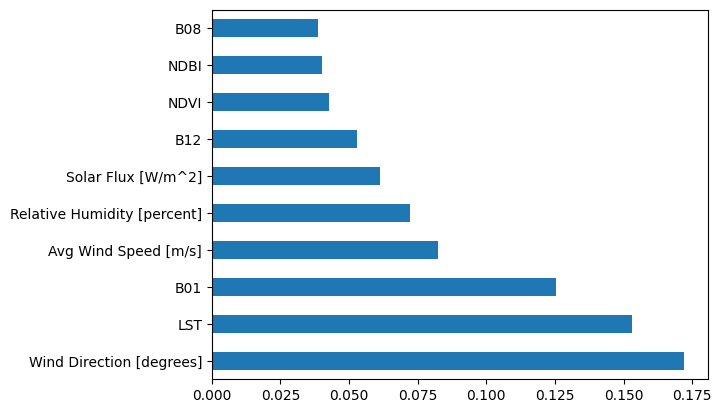

In [40]:
#Plot
feat_importances = pd.Series(reg.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

<p align="justify"> Now let us select the columns required for our model building exercise. We will consider only Band B01, Band B06 and NDVI from the Sentinel-2 data as our predictor variables. It does not make sense to use latitude and longitude as predictor variables, as they do not have any direct impact on predicting the UHI index.</p>


In [ ]:
uhi_data.loc[:,['NDBI','lst', 'UHI Index']].corr()

,NDBI,lst,UHI Index
NDBI,1.000000,0.453366,0.226419
lst,0.453366,1.000000,0.368198
UHI Index,0.226419,0.368198,1.000000


In [41]:
# Retaining only the columns for the most important features in the dataset.
uhi_final = uhi_data[['B01', 'B12', 'NDVI','NDBI','LST',
                     'Building', 'Avg Wind Speed [m/s]', 'Solar Flux [W/m^2]',
                     'Relative Humidity [percent]','UHI Index']]

In [ ]:
uhi_data = uhi_data[['NDVI','NDBI','UHI Index', 'lst']]

### Train and Test Split

<p align="justify">We will now split the data into 70% training data and 30% test data. Scikit-learn alias “sklearn” is a robust library for machine learning in Python. The scikit-learn library has a <i><b>model_selection</b></i> module in which there is a splitting function <i><b>train_test_split</b></i>. You can use the same.</p>

In [68]:
# Split the data into features (X) and target (y), and then into training and testing sets
X = uhi_final.drop(columns=['UHI Index']).values
y = uhi_final['UHI Index'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)

### Feature Scaling

<p align="justify"> Before initiating the model training we may have to execute different data pre-processing steps. Here we are demonstrating the scaling of B01, B06, NDVI variable by using Standard Scaler.</p>

<p align = "justify">Feature Scaling is a data preprocessing step for numerical features. Many machine learning algorithms like Gradient descent methods, KNN algorithm, linear and logistic regression, etc. require data scaling to produce good results. Scikit learn provides functions that can be used to apply data scaling. Here we are using Standard Scaler. The idea behind Standard Scaler is that it will transform your data such that its distribution will have a mean value 0 and standard deviation of 1.</p>

<h4 style="color:rgb(255, 255, 0)"><strong>Tip 4</strong></h4>
<p align="justify">There are many data preprocessing methods available, which might help to improve the model performance. Participants should explore various suitable preprocessing methods as well as different machine learning algorithms to build a robust model.</p>

In [69]:
# Scale the training and test data using standardscaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
mmscaler = MinMaxScaler()
X_train = mmscaler.fit_transform(X_train)
X_test = mmscaler.transform(X_test)

### Model Training

<p align="justify">Now that we have the data in a format suitable for machine learning, we can begin training a model. In this demonstration notebook, we will use a random forest regression model from the scikit-learn library. This library offers a wide range of other models, each with extensive parameter tuning and customization capabilities.</p>

<p align="justify">Scikit-learn models require the separation of predictor variables and the response variable. We will store the predictor variables (Band B01, B06, NDVI) in array X and the response variable (UHI index) in array Y. It is important not to include the response variable in array X. Additionally, since latitude and longitude do not contribute to the prediction of UHI in this case, we will drop those as well.</p>


In [81]:
# Train the Random Forest model on the training data
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train,y_train)

RandomForestRegressor(random_state=42)

In [73]:
# Train XGBoost Model
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [129]:
#Train adaboostregressor
from sklearn.ensemble import AdaBoostRegressor
model = AdaBoostRegressor(estimator=DecisionTreeRegressor(random_state=42, max_depth=10),n_estimators=500, learning_rate=1, random_state=42)
model.fit(X_train, y_train)

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=10,
                                                  random_state=42),
                  learning_rate=1, n_estimators=500, random_state=42)

In [84]:
#Parameter tuning
# Define the parameter grid
param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10, 15, 20],
        'min_samples_leaf': [2, 4, 6, 8],
        'max_features': ['auto', 'sqrt', 'log2', None]
}

In [76]:
#param grid for xgboost
param_grid = {
    'n_estimators': [100, 150, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 6, 9, 12],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

In [126]:
#Param grid for adaboost
param_grid = {
        'n_estimators': [50, 100, 200, 500],
        'learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0],
        'estimator__max_depth': [2, 4, 6, 8, 10]  # Depth of decision trees
        }


In [54]:
from sklearn.model_selection import GridSearchCV

In [127]:
#Gridsearch CV
gs = GridSearchCV(model,param_grid=param_grid,scoring='r2',cv=5,verbose=1, n_jobs=-1)
gs.fit(X_train, y_train)
gs.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'estimator__max_depth': 10, 'learning_rate': 1.0, 'n_estimators': 500}

In [85]:
gs = GridSearchCV(model,param_grid=param_grid,scoring='r2',cv=3,verbose=1, n_jobs=-1)
gs.fit(X_train, y_train)
gs.best_params_

Fitting 3 folds for each of 1200 candidates, totalling 3600 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, 40, 50],
                         'max_features': ['auto', 'sqrt', 'log2', None],
                         'min_samples_leaf': [2, 4, 6, 8],
                         'min_samples_split': [2, 5, 10, 15, 20],
                         'n_estimators': [100, 200, 300]},
             scoring='r2', verbose=1)

{'max_depth': 40,
 'max_features': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

## Model Evaluation

<p align="justify">Now that we have trained our model, the next step is to evaluate its performance. For evaluation, we will use the R² score, a common metric for regression models that measures how well the model explains the variance in the response variable (UHI index). Scikit-learn provides many other metrics that can be used for evaluation, and you can also write custom code for more specific evaluation needs.</p>


### In-Sample Evaluation
<p align="justify">We will be evaluating our model's performance using the R² score on the training data. It is important to note that this is in-sample performance testing, which involves evaluating the model on the training dataset. These metrics are not truly indicative of the model's ability to generalize. You should reserve testing on the test data before drawing final conclusions about your model's performance.</p>


<p align="justify">In this section, we make predictions on the training set and store them in the <b><i>insample_predictions</i></b> variable. The R² score is then calculated to gauge the model's performance on the training data. It is important to keep in mind that this evaluation is for the training set, and further testing on the test set is necessary to assess the model's generalizability.</p>


In [98]:
#Update new model with tuned parameter
model = RandomForestRegressor(n_estimators=300, min_samples_split=2, min_samples_leaf=2, max_features=None, max_depth=40, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=40, max_features=None, min_samples_leaf=2,
                      n_estimators=300, random_state=42)

In [132]:
#Update XGBoost Model with tuned parameter
model = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=12, random_state=42, colsample_bytree =0.8, subsample = 0.8)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [133]:
# Make predictions on the training data
insample_predictions = model.predict(X_train)
# calculate R-squared score for in-sample predictions
Y_train = y_train.tolist()
r2_score(Y_train, insample_predictions)

0.9973952770233154

### Out-Sample Evaluation

When evaluating a machine learning model, it is essential to correctly and fairly evaluate the model's ability to generalize. This is because models have a tendency to overfit the dataset they are trained on. To estimate the out-of-sample performance, we will predict on the test data now.

In [134]:
# Make predictions on the test data
outsample_predictions = model.predict(X_test)

# calculate R-squared score for out-sample predictions
Y_test = y_test.tolist()
r2_score(Y_test, outsample_predictions)

0.8201900124549866

## Submission

Once you are satisfied with your model, you can proceed to make a submission. To do this, you will need to use your model to predict the Urban Heat Island (UHI) index for a set of test coordinates provided in the <b>"Submission_template.csv"</b> file and upload the results to the challenge platform.

In [106]:
#Reading the coordinates for the submission
csv_submission = '/content/drive/MyDrive/Colab Notebooks/EY Data Challenge/Submission_template.csv'
test_file = pd.read_csv(csv_submission)
test_file.head()

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,NaN
1,-73.971928,40.788875,NaN
2,-73.967080,40.789080,NaN
3,-73.972550,40.789082,NaN
4,-73.969697,40.787953,NaN


In [ ]:
# Mapping satellite data for submission.
val_data = map_satellite_data('S2_sample.tiff', 'Submission_template.csv')

Mapping values: 100%|██████████| 1040/1040 [00:01<00:00, 594.00it/s]


In [108]:
# Mapping satellite data for submission.
val_data = test(tiff_path=tiff_path, csv_path=csv_submission, buffer_distance=0)

Processing locations: 100%|██████████| 1040/1040 [00:05<00:00, 192.92it/s]


In [109]:
# Calculate NDVI (Normalized Difference Vegetation Index) and handle division by zero by replacing infinities with NaN.
val_data['NDVI'] = (val_data['B08'] - val_data['B04']) / (val_data['B08'] + val_data['B04'])
val_data['NDVI'] = val_data['NDVI'].replace([np.inf, -np.inf], np.nan)  # Replace infinities with NaN

In [110]:
val_data.head()

,Longitude,Latitude,UHI Index,B01,B02,B03,B04,B08,B12,NDVI
0,-73.971665,40.788763,NaN,652.5,360.5,499.0,384.0,1997.0,835.5,0.677446
1,-73.971928,40.788875,NaN,1044.0,425.0,575.0,470.0,3434.0,1094.5,0.759221
2,-73.967080,40.789080,NaN,723.5,745.5,864.5,811.5,1090.0,584.0,0.146463
3,-73.972550,40.789082,NaN,971.5,542.5,671.5,824.0,1036.5,1468.5,0.114217
4,-73.969697,40.787953,NaN,911.5,694.0,818.0,754.5,2185.0,1404.0,0.486647


In [ ]:
# Extracting specific columns (B01, B06, and NDVI) from the validation dataset
submission_val_data=val_data.loc[:,['B01','B06','NDVI']]
submission_val_data.head()

,B01,B06,NDVI
0,811.0,2089.0,0.705521
1,1208.0,2076.0,0.635801
2,899.0,995.0,0.023829
3,1193.0,1939.0,0.079732
4,1097.0,2204.0,0.253428


In [111]:
# Feature Scaling
submission_val_data = submission_val_data.values
transformed_submission_data = sc.transform(submission_val_data)

NameError: name 'submission_val_data' is not defined

In [ ]:
#Making predictions
final_predictions = model.predict(transformed_submission_data)
final_prediction_series = pd.Series(final_predictions)

In [ ]:
#Combining the results into dataframe
submission_df = pd.DataFrame({'Longitude':test_file['Longitude'].values, 'Latitude':test_file['Latitude'].values, 'UHI Index':final_prediction_series.values})

In [ ]:
#Displaying the sample submission dataframe
submission_df.head()

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,0.974508
1,-73.971928,40.788875,0.975031
2,-73.967080,40.789080,0.975424
3,-73.972550,40.789082,0.987028
4,-73.969697,40.787953,0.963467


In [ ]:
#Dumping the predictions into a csv file.
submission_df.to_csv("submission.csv",index = False)

### Upload submission file on platform

Upload the submission.csv on the <a href ="https://challenge.ey.com">platform</a> to get score generated on scoreboard.

## Conclusion

<div align ="justify">Now that you have learned a basic approach to model training, it’s time to try your own approach! Feel free to modify any of the functions presented in this notebook. We look forward to seeing your version of the model and the results. Best of luck with the challenge!</div>